### **MOCK E-COMMERCE DATASET**
#### Practicing Basic SQL Queries, and both SQL and Pandas Data Aggregation, and Data GroupBy
#### **Libraries:** Pandas, Sqlite3, Matplotlib (for Data Viz)

In [590]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Dataset**

In [591]:
data = {
    'transaction_id': range(101, 121),
    'date': [
        '2024-01-15','2024-01-16','2024-01-20','2024-02-01','2024-02-05',
        '2024-02-10','2024-03-01','2024-03-05','2024-03-10','2024-03-12',
        '2024-01-15','2024-01-18','2024-02-20','2024-02-22','2024-03-15',
        '2024-03-18','2024-01-05','2024-02-14','2024-03-25','2024-03-30'
    ],
    'category': [
        'Electronics','Electronics','Clothing','Home','Electronics',    
        'Clothing','Home','Electronics','Home','Clothing',
        'Electronics','Home','Clothing','Electronics','Home',
        'Clothing','Electronics','Home','Clothing','Electronics'
    ],
    'product': [
        'Laptop','Headphones','T-Shirt','Blender','Monitor',
        'Jeans','Sofa','Mouse','Lamp','Jacket',
        'Laptop','Table','Sneakers','Headphones','Rug',
        'Hat','Tablet','Chair','Scarf','Keyboard'
    ],
    'amount': [
        1200,150,25,80,300,
        50,500,40,60,120,
        1200,150,80,150,100,
        20,400,200,30,80
    ],
    'region': [
        'North','North','East','West','North',
        'East','West','South','West','East',
        'South','West','North','South','East',
        'East','North','South','West','South'
    ]
}

sql_df = pd.DataFrame(data)
sql_df = sql_df.values.tolist()

### Establish SQL Connection and Cursor

In [592]:
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

cursor.execute("""
    CREATE TABLE e_commerce(
        transaction_id INT PRIMARY KEY,
        date TEXT,
        category TEXT,
        product TEXT,
        amount INT,
        region TEXT
)               
""")

cursor.executemany('INSERT INTO e_commerce VALUES (?, ?, ?, ?, ?, ?)', sql_df)

In [593]:
def read_query(queries):
    return pd.read_sql_query(queries, conn)

sql_table = '''
    SELECT * FROM e_commerce
    LIMIT 5
'''

display(read_query(sql_table))

,transaction_id,date,category,product,amount,region
0,101,2024-01-15,Electronics,Laptop,1200,North
1,102,2024-01-16,Electronics,Headphones,150,North
2,103,2024-01-20,Clothing,T-Shirt,25,East
3,104,2024-02-01,Home,Blender,80,West
4,105,2024-02-05,Electronics,Monitor,300,North


### TRANSFROMING A DATAFRAME INTO A CSV FILE

In [594]:
pandas_df = pd.DataFrame(data)
pandas_df.head(5)

,transaction_id,date,category,product,amount,region
0,101,2024-01-15,Electronics,Laptop,1200,North
1,102,2024-01-16,Electronics,Headphones,150,North
2,103,2024-01-20,Clothing,T-Shirt,25,East
3,104,2024-02-01,Home,Blender,80,West
4,105,2024-02-05,Electronics,Monitor,300,North


In [595]:
pandas_df.to_csv('e-commerce.csv')

In [596]:
df2 = pd.read_csv('e-commerce.csv')
df2 = df2.drop(columns=['Unnamed: 0']) # dropping unnecessary column

df2.head(5)

,transaction_id,date,category,product,amount,region
0,101,2024-01-15,Electronics,Laptop,1200,North
1,102,2024-01-16,Electronics,Headphones,150,North
2,103,2024-01-20,Clothing,T-Shirt,25,East
3,104,2024-02-01,Home,Blender,80,West
4,105,2024-02-05,Electronics,Monitor,300,North


### **PROBLEM 1: Track The Total Sales**
#### Aggregate the following **amount** column using Pandas and SQL Query to calculate total revenue.

In [597]:
total_sales = """
    select sum(amount) from e_commerce
"""
display(read_query(total_sales))

,sum(amount)
0,4935


In [598]:
total_revenue= df2['amount'].sum()
print(f'Total Revenue from Sales: {total_revenue}')

Total Revenue from Sales: 4935


### **PROBLEM 2: Sales by Category**
#### Task: Group the dataset by category and compute:
- total sales
- average transaction amount
- number of transactions

In [599]:
sales = """
    select 
        category,
        round(avg(amount), 2) as transaction_amount,
        count(transaction_id) as num_of_transactions
    from e_commerce
    group by category
"""

display(read_query(sales))

,category,transaction_amount,num_of_transactions
0,Clothing,54.17,6
1,Electronics,440.00,8
2,Home,181.67,6


In [600]:
sales_by_category = df2.groupby('category').agg({'amount' : 'mean', 'transaction_id' : 'count'}).reset_index().round(2)
sales_by_category.rename(
    columns={'amount' : 'avg_transact_amount', 'transaction_id' : 'no_of_transactions'}
)
sales_by_category

,category,amount,transaction_id
0,Clothing,54.17,6
1,Electronics,440.00,8
2,Home,181.67,6


### **PROBLEM 3: Top 3 Highest-Spending Transactions**
#### Task: Display the top 3 transactions from diff. categories with the largest amount.

In [601]:
top_3 = """
    select 
        category,
        max(amount) as top_transactions
    from e_commerce
    group by category
    order by top_transactions desc
"""

display(read_query(top_3))

,category,top_transactions
0,Electronics,1200
1,Home,500
2,Clothing,120


In [602]:
top3 = df2.loc[df2.groupby('category')['amount'].idxmax()]

# unnecessary columns
top3 = top3.drop(columns=['transaction_id', 'date', 'product', 'region'])

# top transactions column & sorting values
top3 = top3.rename(columns={'amount' : 'top_transactions'}).sort_values(by='top_transactions', ascending=False)

top3

,category,top_transactions
0,Electronics,1200
6,Home,500
9,Clothing,120


### **PROBLEM 4: Sales by Region (Bar Chart)**
#### Task: Group by region and plot:
#### 📊 A bar chart of total sales per region.

In [603]:
cursor.execute("""
    alter table e_commerce
    rename column region to Region
""")

conn.commit()

sales_by_region = """
    select
        Region,
        sum(amount) as "Total Sales"
    from e_commerce
    group by Region
    order by "Total Sales" desc
"""
display(read_query(sales_by_region))

data_vis = read_query(sales_by_region)

,Region,Total Sales
0,North,2130
1,South,1670
2,West,820
3,East,315


C:\Users\LEI\AppData\Local\Temp\ipykernel_18556\1523955311.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Total Sales', data=data_vis, palette='pastel')


<Axes: title={'center': 'Sales Revenue per Region'}, xlabel='Region', ylabel='Total Sales'>

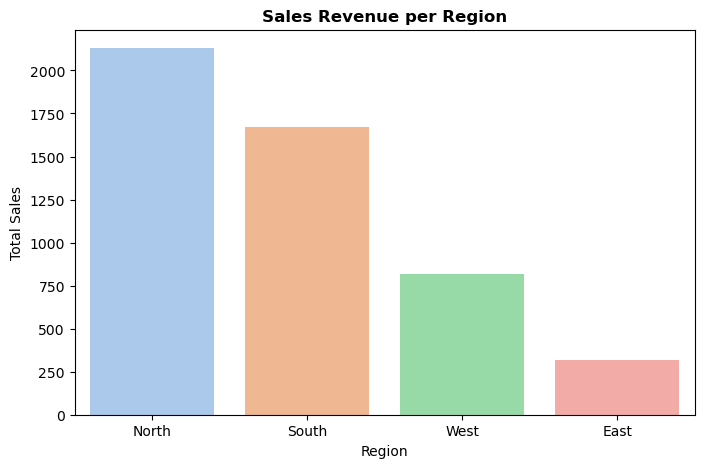

In [604]:
plt.figure(figsize=(8, 5))
plt.title('Sales Revenue per Region', fontweight='bold')
sns.barplot(x='Region', y='Total Sales', data=data_vis, palette='pastel')

In [605]:
from matplotlib import colormaps

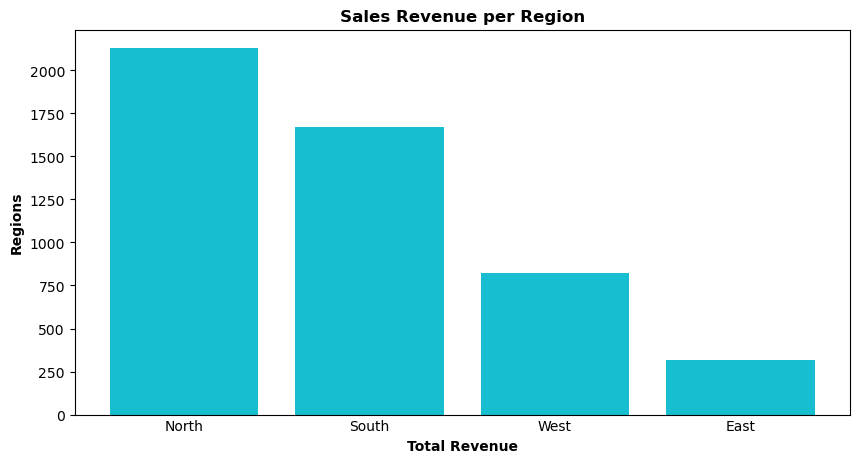

In [606]:
region_sales = df2.groupby('region').agg({'amount' : 'sum'}).reset_index().sort_values(by='amount', ascending=False)
region_sales = region_sales.rename(columns={'region' : 'Region', 'amount' : 'Total Sales'})

plt.figure(figsize=(10, 5))
plt.title('Sales Revenue per Region', fontweight='bold')
plt.bar(region_sales['Region'], region_sales['Total Sales'], color='C9')
plt.xlabel('Total Revenue', fontweight='bold')
plt.ylabel('Regions', fontweight='bold')
plt.tick_params(axis='x', length=0)

In [607]:
region_sales

,Region,Total Sales
1,North,2130
2,South,1670
3,West,820
0,East,315


### **PROBLEM 5: Monthly Sales Trend (Line Chart)**
#### Task: Convert date to datetime and create a new column month.
#### Plot a line graph showing the sum of sales per month.

In [608]:
df2['date'] = pd.to_datetime(df2['date'])
df2['month'] = df2['date'].dt.month
df2

,transaction_id,date,category,product,amount,region,month
0,101,2024-01-15,Electronics,Laptop,1200,North,1
1,102,2024-01-16,Electronics,Headphones,150,North,1
2,103,2024-01-20,Clothing,T-Shirt,25,East,1
3,104,2024-02-01,Home,Blender,80,West,2
4,105,2024-02-05,Electronics,Monitor,300,North,2
5,106,2024-02-10,Clothing,Jeans,50,East,2
6,107,2024-03-01,Home,Sofa,500,West,3
7,108,2024-03-05,Electronics,Mouse,40,South,3
8,109,2024-03-10,Home,Lamp,60,West,3
9,110,2024-03-12,Clothing,Jacket,120,East,3


In [609]:
monthly_sales = df2.groupby('month').agg({'amount' : 'sum'}).reset_index()
monthly_sales['month'] = monthly_sales['month'].astype(int)
monthly_sales

,month,amount
0,1,3125
1,2,860
2,3,950


Text(0, 0.5, 'Revenue')

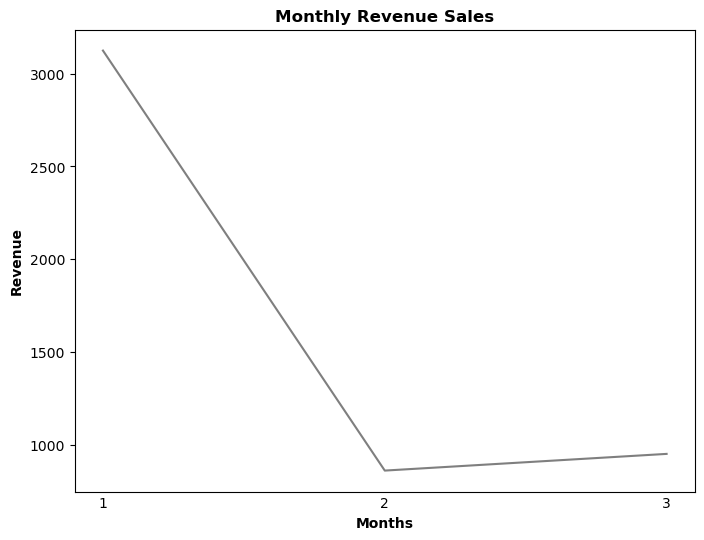

In [610]:
plt.figure(figsize=(8, 6))
plt.title('Monthly Revenue Sales', fontweight='bold')
plt.plot(monthly_sales['month'], monthly_sales['amount'], color='C7')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tick_params(axis='x', length=0)
plt.xlabel('Months', fontweight='bold')
plt.ylabel('Revenue', fontweight='bold')

In [611]:
monthly_sales_query = """
    select 
        strftime('%m', date) AS month,
        sum(amount) as total_revenue
    from e_commerce
    group by month
"""

display(read_query(monthly_sales_query))

,month,total_revenue
0,01,3125
1,02,860
2,03,950


#### **PRACTICE PIVOT TABLES, SUBSETTING, AND VISUALIZATIONS**

In [612]:
print(df2)

    transaction_id       date     category     product  amount region  month
0              101 2024-01-15  Electronics      Laptop    1200  North      1
1              102 2024-01-16  Electronics  Headphones     150  North      1
2              103 2024-01-20     Clothing     T-Shirt      25   East      1
3              104 2024-02-01         Home     Blender      80   West      2
4              105 2024-02-05  Electronics     Monitor     300  North      2
5              106 2024-02-10     Clothing       Jeans      50   East      2
6              107 2024-03-01         Home        Sofa     500   West      3
7              108 2024-03-05  Electronics       Mouse      40  South      3
8              109 2024-03-10         Home        Lamp      60   West      3
9              110 2024-03-12     Clothing      Jacket     120   East      3
10             111 2024-01-15  Electronics      Laptop    1200  South      1
11             112 2024-01-18         Home       Table     150   West      1

In [613]:
sales_region = df2.pivot_table(values='amount', index='region', columns='category', aggfunc='mean', fill_value=0)
print(sales_region)

category  Clothing  Electronics   Home
region                                
East         53.75          0.0  100.0
North        80.00        512.5    0.0
South         0.00        367.5  200.0
West         30.00          0.0  197.5


In [614]:
sales_date = df2.pivot_table(values='amount', index='date')
print(sales_date)

            amount
date              
2024-01-05   400.0
2024-01-15  1200.0
2024-01-16   150.0
2024-01-18   150.0
2024-01-20    25.0
2024-02-01    80.0
2024-02-05   300.0
2024-02-10    50.0
2024-02-14   200.0
2024-02-20    80.0
2024-02-22   150.0
2024-03-01   500.0
2024-03-05    40.0
2024-03-10    60.0
2024-03-12   120.0
2024-03-15   100.0
2024-03-18    20.0
2024-03-25    30.0
2024-03-30    80.0


In [615]:
sales_monthly = df2.pivot_table(values='amount', index='month', columns='category', )
print(sales_monthly)

category   Clothing  Electronics   Home
month                                  
1         25.000000        737.5  150.0
2         65.000000        225.0  140.0
3         56.666667         60.0  220.0


In [616]:
total_monthly_sales = df2.groupby('category')['amount'].sum().reset_index().sort_values('amount', ascending=False)
print(total_monthly_sales)

      category  amount
1  Electronics    3520
2         Home    1090
0     Clothing     325


Text(0, 0.5, 'Product Category')

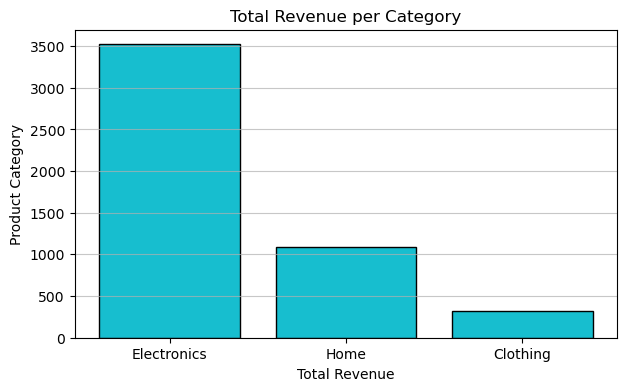

In [617]:
plt.figure(figsize=(7, 4))
plt.title('Total Revenue per Category')
plt.bar(total_monthly_sales['category'], total_monthly_sales['amount'], edgecolor='black', color='C9')
plt.grid(axis='y', alpha=0.7)
plt.xlabel('Total Revenue')
plt.ylabel('Product Category')